In [1]:
import os
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose
from keras.models import Sequential, Model
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import VGG16, ResNet50, InceptionV3, InceptionResNetV2

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
# Constants
training = False
model_path = "../../out/models/weights.50-0.67.hdf5"
base_data_dir = "../../out/robot--4209387126734636757/"
image_size = (128, 128)
input_shape = (*image_size, 1)
epochs = 50
batch_size = 64
test_split = 0.1

In [5]:
# Rangle data
x = []
y = []
for world_name in tqdm(list(os.listdir(base_data_dir))):
    world_dir = os.path.join(base_data_dir, world_name)
    world_x = []
    world_y = []
    for file_name in os.listdir(world_dir):
        _, extension = os.path.splitext(file_name)
        if extension != ".bmp":
            continue
        image = imread(os.path.join(world_dir, file_name), as_gray=True)
        if file_name == "regions.bmp":
            world_y.append(image)
        else:
            world_x.append(image)
    world_y *= len(world_x)
    x.extend(world_x)
    y.extend(world_y)
x = np.array(x).astype("float32") / 255
y = np.array(y).astype("float32") / 255
x = np.reshape(x, (len(x), *input_shape))
y = np.reshape(y, (len(y), *input_shape))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_split, shuffle=False)

100%|██████████| 970/970 [02:21<00:00,  6.85it/s]


In [8]:
# # Build fully convolutional network
# fcn = Sequential()
# fcn.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=input_shape))
# fcn.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
# fcn.add(MaxPooling2D((2, 2), strides=(2, 2)))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(MaxPooling2D((2, 2), strides=(2, 2)))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(UpSampling2D((2, 2)))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
# fcn.add(UpSampling2D((2, 2)))
# fcn.add(Conv2D(1, (1, 1), padding="same", activation="sigmoid"))

# Other networks to test
base_model = ResNet50(include_top=False, weights=None, input_shape=input_shape)
# base_model = VGG16(include_top=False, weights=None, input_shape=input_shape)
# base_model = InceptionV3(include_top=False, weights=None, input_shape=input_shape)
# base_model = InceptionResNetV2(include_top=False, weights=None, input_shape=input_shape)
x = base_model.output
x = UpSampling2D((4, 4))(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (1, 1), activation="sigmoid")(x)
fcn = Model(input=base_model.input, output=x)

fcn.load_weights(model_path)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


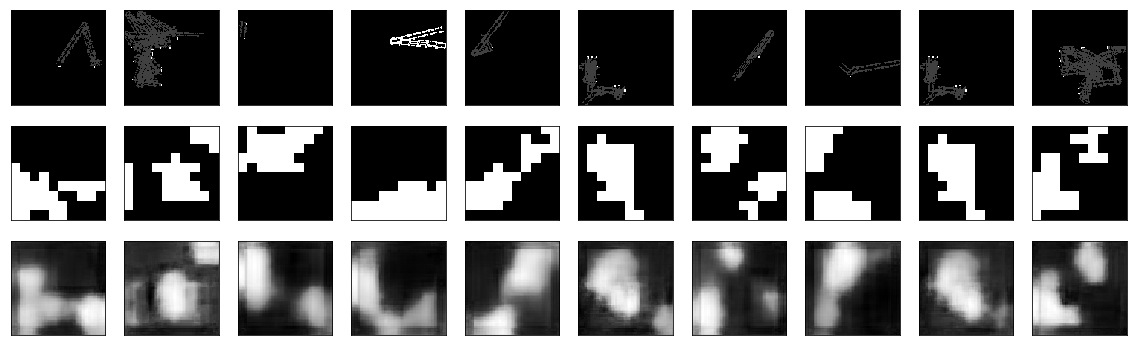

In [11]:
# Visually evaluate results
n = 10
indices = np.random.permutation(len(x_test))[:n + 1]
x_test = x_test[indices]
y_test = y_test[indices]
predictions = fcn.predict(x_test)
plt.figure(figsize=(20, 6))
plt.gray()
for i in range(1, n + 1):
    # display original
    ax = plt.subplot(3, n, i + 0 * n)
    plt.imshow(x_test[i].reshape(*image_size))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display truth
    ax = plt.subplot(3, n, i + 1 * n)
    plt.imshow(y_test[i].reshape(*image_size))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display prediction
    ax = plt.subplot(3, n, i + 2 * n)
    plt.imshow(predictions[i].reshape(*image_size))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()